### _in silico_ perturbation by cell type prompting

In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

In [2]:
ROOT_PATH = "/home/mehrtash/data"
CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient",
    verbose=False
)

In [3]:
# arguments
query_gene_ids = ctx.model_var_names
assay = "10x 3' v2"
suspension_type = "cell"
prompt_metadata_dict = {
    "cell_type": "CD8-positive, alpha-beta T cell",
    "tissue": "blood"
}
total_mrna_umis = 10_000

### Gene expression dynamic range determination

In [4]:
query_chunk_size = 1_000
upper_percentile = 0.95
max_counts = 1000
upper_pad = 1

gex_range_dict = ctx.predict_gene_expression_range_for_metadata(
    assay=assay,
    suspension_type=suspension_type,
    prompt_metadata_dict=prompt_metadata_dict,
    total_mrna_umis=total_mrna_umis,
    query_gene_ids=query_gene_ids,
    query_chunk_size=query_chunk_size,
    upper_percentile=upper_percentile,
    upper_pad=upper_pad,
    max_counts=max_counts,
)

Processing gene chunks:   0%|          | 0/37 [00:00<?, ?it/s]

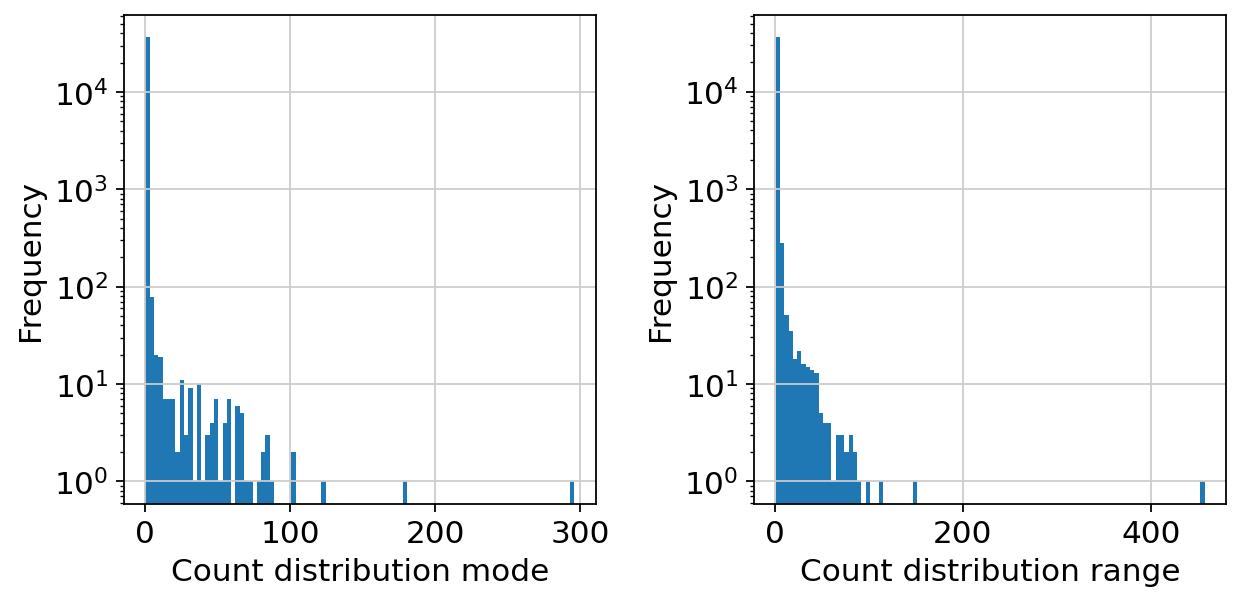

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax = axs[0]
ax.hist(gex_range_dict['gene_logits_mode_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Count distribution mode");
ax.set_ylabel("Frequency");

ax = axs[1]
ax.hist(gex_range_dict['range_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Count distribution range");
ax.set_ylabel("Frequency");

fig.tight_layout()

In [50]:
# print gene symbols for top 10 genes in terms of mode
top_k = 50
top_k_genes = sorted(
    zip(query_gene_ids, gex_range_dict['gene_logits_mode_q'].cpu().numpy()), key=lambda x: x[1], reverse=True)[:top_k]
for gene_id, mode in top_k_genes:
    print(f'{ctx.gene_id_to_gene_symbol_map[gene_id]}, mode: {mode}')

MALAT1, mode: 296
TMSB4X, mode: 179
B2M, mode: 122
EEF1A1, mode: 102
RPS27, mode: 102
RPS18, mode: 86
RPL13A, mode: 83
RPL10, mode: 83
RPL41, mode: 83
RPLP1, mode: 81
RPS12, mode: 81
RPL13, mode: 78
RPS2, mode: 73
RPL21, mode: 71
RPS19, mode: 68
RPS29, mode: 68
RPL34, mode: 68
RPLP2, mode: 66
RPL28, mode: 66
RPL32, mode: 63
RPS27A, mode: 63
RPS14, mode: 63
RPS15A, mode: 63
RPS3, mode: 63
RPS6, mode: 63
RPL3, mode: 57
RPL18A, mode: 57
RPS23, mode: 57
TMSB10, mode: 57
RPS4X, mode: 57
MT-CO1, mode: 57
ACTB, mode: 57
RPL39, mode: 56
RPL11, mode: 56
RPL27A, mode: 56
RPL26, mode: 54
RPL23A, mode: 52
RPS3A, mode: 50
RPS28, mode: 49
RPL19, mode: 49
RPS15, mode: 49
RPL15, mode: 49
RPS8, mode: 49
TPT1, mode: 49
MT-CO3, mode: 45
MT-CO2, mode: 45
RPL7, mode: 45
RPL37A, mode: 45
RPL30, mode: 43
RPS25, mode: 43


mode: 179, range: 149
lo: 30, hi: 328


Text(0, 0.5, 'Probability')

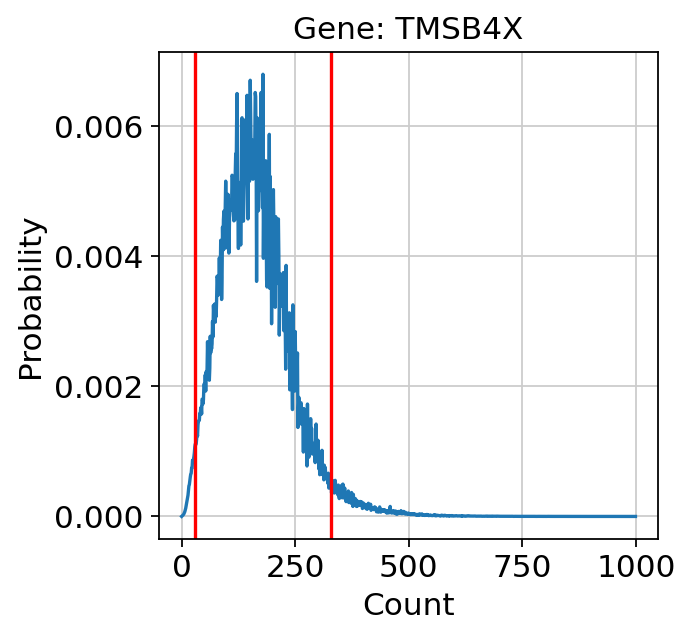

In [48]:
gene_symbol = 'TMSB4X'
q = ctx.var_name_to_index_map[ctx.gene_symbol_to_gene_id_map[gene_symbol]]

print(f"mode: {gex_range_dict['gene_logits_mode_q'][q].item()}, range: {gex_range_dict['range_q'][q].item()}")
print(f"lo: {gex_range_dict['x_lo_q'][q].item()}, hi: {gex_range_dict['x_hi_q'][q].item()}")

query_id = query_gene_ids[q]
gene_symbol = ctx.gene_id_to_gene_symbol_map[query_id]

fig, ax = plt.subplots()

ax.plot(
    np.arange(max_counts),
    gex_range_dict['gene_logits_qk'][q].exp().cpu().numpy(), '-')
ax.axvline(gex_range_dict['x_lo_q'][q].item(), color='red')
ax.axvline(gex_range_dict['x_hi_q'][q].item(), color='red')

ax.set_title(f"Gene: {gene_symbol}")
ax.set_xlabel("Count")
ax.set_ylabel("Probability")

In [7]:
gene_logits_qk = gex_range_dict['gene_logits_qk']
gene_logits_mode_q = gex_range_dict['gene_logits_mode_q']
range_q =  gex_range_dict['range_q']
x_lo_q = gex_range_dict['x_lo_q']
x_hi_q = gex_range_dict['x_hi_q']

# let's pick genes to perturb (and query) that make sense for this cell type
min_upper_range = 5
expressed_mask_q = (x_hi_q >= min_upper_range).cpu().numpy()
filtered_query_gene_ids = query_gene_ids[expressed_mask_q]
filtered_perturb_gene_ids = query_gene_ids[expressed_mask_q]
filtered_query_gene_symbols = [ctx.gene_id_to_gene_symbol_map[gid] for gid in filtered_query_gene_ids]
filtered_perturb_gene_symbols = [ctx.gene_id_to_gene_symbol_map[gid] for gid in filtered_perturb_gene_ids]
filtered_x_lo_q = x_lo_q.cpu().numpy()[expressed_mask_q]
filtered_x_hi_q = x_hi_q.cpu().numpy()[expressed_mask_q]
print("Number of genes to perturb:", len(filtered_perturb_gene_ids))
print("Number of genes to query:", len(filtered_query_gene_ids))

Number of genes to perturb: 898
Number of genes to query: 898


In [8]:
n_points = 10
query_chunk_size = 64

dose_response_dict = ctx.generate_gene_dose_response_for_metadata(
    assay=assay,
    suspension_type=suspension_type,
    prompt_metadata_dict=prompt_metadata_dict,
    total_mrna_umis=total_mrna_umis,
    query_gene_ids=filtered_query_gene_ids,
    perturb_gene_ids=filtered_perturb_gene_ids,
    x_lo_p=filtered_x_lo_q,
    x_hi_p=filtered_x_hi_q,
    n_points=n_points,
    query_chunk_size=query_chunk_size,
    max_counts=max_counts,
)

Processing dose quantiles:   0%|          | 0/10 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
dose_response_dict.keys()

dict_keys(['doses_pi', 'responses_mean_pqi', 'responses_std_pqi', 'control_mean_q', 'control_std_q'])

In [9]:
for i, gene_id in enumerate(filtered_query_gene_ids):
    print(i, filtered_query_gene_symbols[i])

0 SERBP1
1 PRPF38B
2 LYAR
3 FGFBP2
4 GZMK
5 CCT6A
6 RPL30
7 IFITM2
8 APEX1
9 DNMT1
10 DSTN
11 RPL3
12 UFC1
13 WDR1
14 NPM1
15 FIS1
16 ATP6V1F
17 PRDX5
18 PRR13
19 ARF6
20 SERF2
21 B2M
22 C1QBP
23 MATK
24 RPL18A
25 GMFG
26 EIF2S2
27 DDT
28 DDX17
29 PGK1
30 AURKAIP1
31 HSPD1
32 UBE2D3
33 RPS23
34 COX7C
35 UQCRQ
36 LMAN2
37 PSMB8
38 DYNLT1
39 CBX3
40 ATP5MF
41 RPL12
42 EIF3M
43 PFDN5
44 GZMH
45 SIVA1
46 SEC11A
47 VAMP2
48 ATP5PD
49 SUMO2
50 ATP5F1A
51 TOMM22
52 NDUFA6
53 EIF1AX
54 EIF3I
55 SCP2
56 JUN
57 SELL
58 PDIA6
59 SRSF7
60 TMBIM6
61 RBM25
62 RPLP1
63 RPL13
64 NME1
65 RABAC1
66 SAMHD1
67 ZFAS1
68 XRCC6
69 SSR4
70 MT-ND4
71 IFI16
72 CXCR4
73 ZEB2
74 TUBA4A
75 ARPC4
76 H1-10
77 RWDD1
78 TALDO1
79 TMEM258
80 MALAT1
81 GSTP1
82 C12orf75
83 CCL4
84 JUNB
85 C19orf53
86 CALM3
87 UBE2L3
88 ATRX
89 EFHD2
90 CD52
91 PRRC2C
92 COX5B
93 RPL14
94 SNHG32
95 COX7A2
96 ATP5F1C
97 RPL6
98 ITM2B
99 MORF4L1
100 ARL6IP1
101 PSMC5
102 RPS11
103 MT-ND3
104 SSU72
105 SRP9
106 CCT4
107 CD47
108 PPP1R2
109 

Text(0, 0.5, 'Response of GZMM')

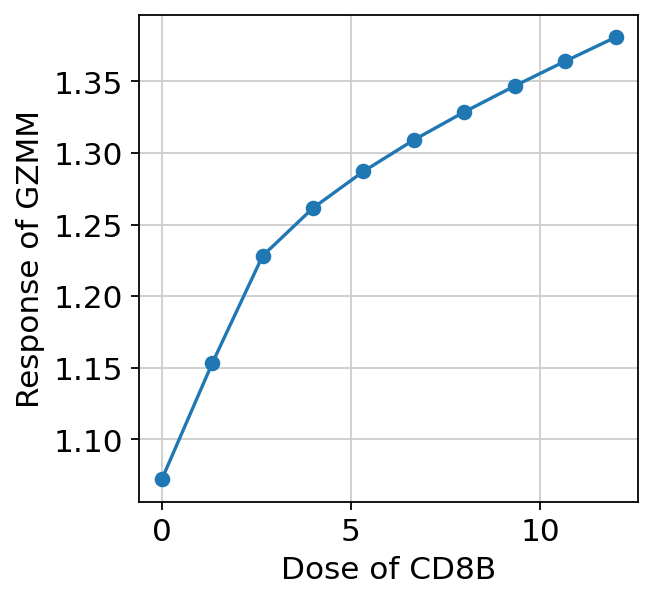

In [35]:
p = filtered_perturb_gene_symbols.index('CD8B')
q = filtered_query_gene_symbols.index('GZMM')

fig, ax = plt.subplots()

ax.plot(dose_response_dict['doses_pi'][p, :], dose_response_dict['responses_mean_pqi'][p, q, :], marker='o')
ax.set_xlabel(f"Dose of {filtered_perturb_gene_symbols[p]}")
ax.set_ylabel(f"Response of {filtered_query_gene_symbols[q]}")